# Version 8
In this notebook, and exploration of the data to find feature importance and which columns affect the results the most.

## Results
cat2 has the lowest feature importance cat2: 0.005
Removing cat2 improved the results slightly.

In [1]:
# reading data from google drive 
# data paths whether notebook is run locally or google colab
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
    TRAIN_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv"
    TEST_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv"
    OUTPUT_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/output"
except:
    TRAIN_DATA_PATH = os.path.join("data", "train.csv")
    TEST_DATA_PATH = os.path.join("data", "test.csv")

print(f"Training Path {TRAIN_DATA_PATH}")
print(f"Testing Path {TEST_DATA_PATH}")

Training Path data/train.csv
Testing Path data/test.csv


In [164]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
from math import *

# preprocessing\
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
# reading the data
df = pd.read_csv(TRAIN_DATA_PATH, index_col='id')
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')

In [5]:
print(f"Shape of Training Data {df.shape}")
print(f"Shape of Testing Data {X_test.shape}")

Shape of Training Data (300000, 25)
Shape of Testing Data (200000, 24)


In [7]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()

In [8]:
def create_num_cols(df):
    return df.select_dtypes(exclude="object").columns.to_list()
def create_cat_cols(df):
    return [cname for cname in df.columns if (df[cname].dtypes=="object")]

num_cnames = create_num_cols(X)
cat_cnames = create_cat_cols(X)
all_cnames = num_cnames + cat_cnames

print(f"There are {len(num_cnames)} Numerical columns")
print(f"There are {len(cat_cnames)} Categorical Columns")
print(f"In total, there are {len(all_cnames)} columns")

There are 14 Numerical columns
There are 10 Categorical Columns
In total, there are 24 columns


# EDA

In [10]:
df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [11]:
def plot_corr(df):
    """Plotting correlation for a given dataframe."

    Args:
        df (dataframe): get the plot for the correlation
    """
    plt.figure(figsize=(15,15))
    mask = np.triu(np.ones(df.corr().shape))
    sns.heatmap(df.corr(), annot=True, mask=mask)


def count_plots_cat(df, num_rows=ceil(len(cat_cnames)/2),num_cols =2 , col_names=cat_cnames):
    """plotting the value counts for categorical variables

    Args:
        df (dataframe): dataframe
        num_rows (int, optional): Number of rows for the ploat. Defaults to ceil(len(cat_cnames)/2).
        num_cols (int, optional): Number of columns for the plotting. Defaults to 2.
        col_names (list, optional): the categorical column names. Defaults to cat_cnames.
    """
    fix, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))
    axes = axes.ravel()
    for i in range(len(col_names)):
        col = col_names[i]
        sns.countplot(df[col], ax=axes[i]);
        axes[i].set_title(f"{col} Distribution");
        axes[i].set_yticklabels([]) # removing labels
        axes[i].set_yticks([]) # removign ticks
        axes[i].set_ylabel("PCT %")
        # removing borders 
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        # showing values in plot
        for patch in axes[i].patches:
            # get the height of the patch
            h = patch.get_height()
            axes[i].text(patch.get_x()+patch.get_width()/2,
                        h+8,'{:.2f}%'.format(h*100/len(df)),
                    fontsize = 12,ha = 'center')




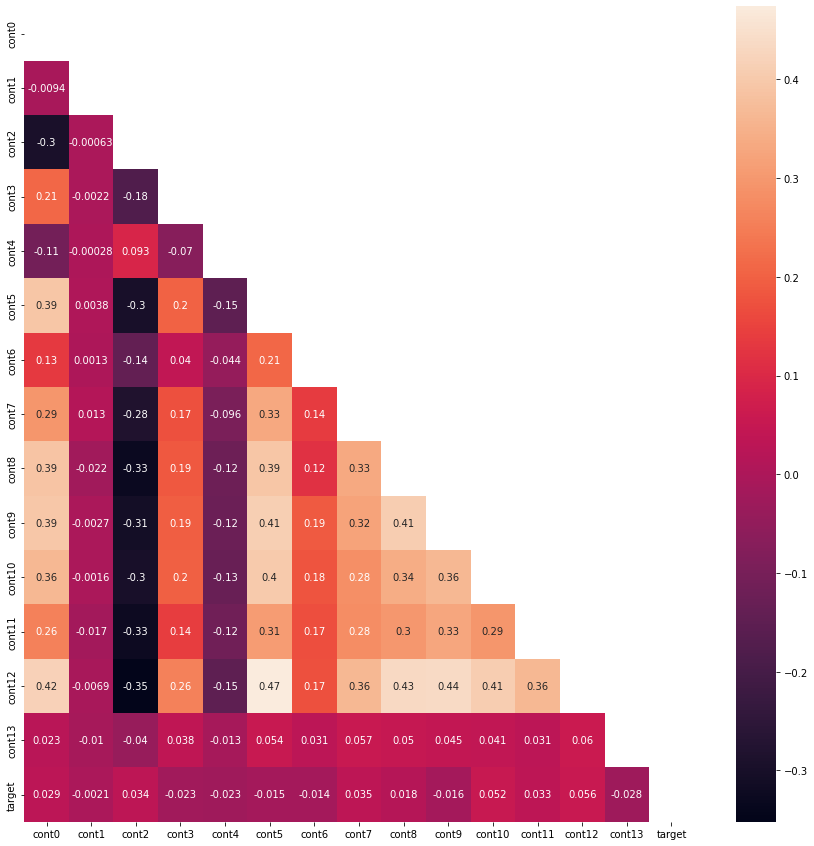

In [12]:
plot_corr(df)

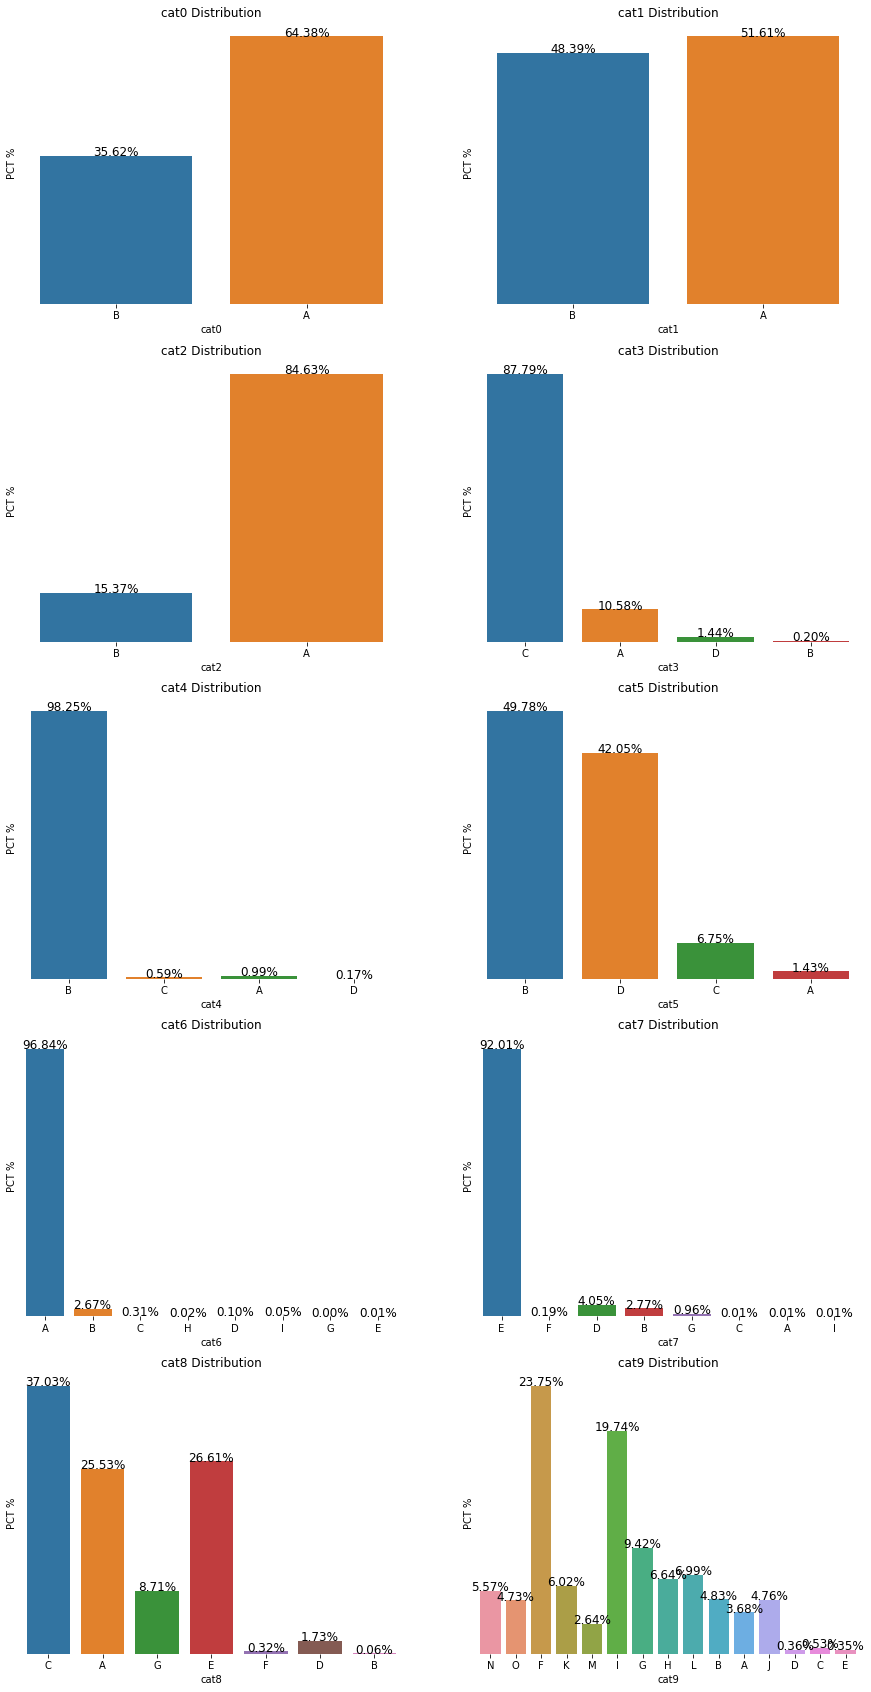

In [13]:
count_plots_cat(df)

{'cat3': ['B'], 'cat4': ['D'], 'cat6': ['D', 'I', 'H', 'E', 'G'], 'cat7': ['F', 'C', 'A', 'I'], 'cat8': ['B']}


## Modeling

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)

In [27]:
estimators = 1500
depth = 3
lr = 0.05

preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), cat_cnames),
], remainder='passthrough')

model = XGBRegressor(n_estimators=estimators, max_depth=depth, learning_rate=lr)

xgb_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', model)
])

In [28]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, boo...
                              interaction_constraints='', learning_rate=0.05,
                            

In [55]:
def model_eval(model, X_v=X_valid, y_v=y_valid):
    predictions = model.predict(X_v)
    rmse = mean_squared_error(y_v, predictions)**0.5
    print(f"RMSE: {rmse}")
    return rmse
    
    

In [60]:
# predictions = xgb_pipeline.predict(X_valid)
# rmse = mean_squared_error(y_valid, predictions)**0.5
print(f"RMSE: {rmse}")

RMSE: 0.7220915189028095


In [38]:
xgb_pipeline['model'].feature_importances

AttributeError: 'XGBRegressor' object has no attribute 'feature_importances'

In [40]:

feature_importance = xgb_pipeline['model'].feature_importances_
print("Feature Importances")
for cname, importance in zip(X.columns, feature_importance):
    print(f"{cname}: {importance:0.3f}")



Feature Importances
cat0: 0.013
cat1: 0.137
cat2: 0.005
cat3: 0.031
cat4: 0.015
cat5: 0.016
cat6: 0.017
cat7: 0.020
cat8: 0.078
cat9: 0.012
cont0: 0.033
cont1: 0.021
cont2: 0.056
cont3: 0.042
cont4: 0.046
cont5: 0.047
cont6: 0.027
cont7: 0.049
cont8: 0.027
cont9: 0.068
cont10: 0.080
cont11: 0.035
cont12: 0.086
cont13: 0.040


Text(0.5, 0, 'Feature Importance')

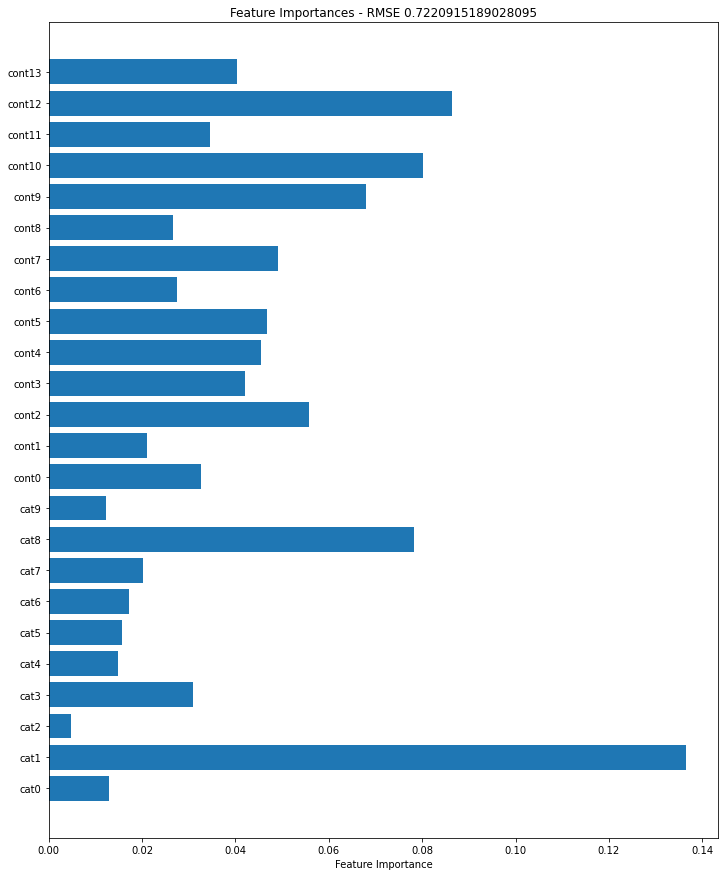

In [43]:
plt.figure(figsize=(12,15))
plt.barh(X.columns, feature_importance)
plt.title(f"Feature Importances - RMSE {rmse}")
plt.xlabel("Feature Importance")

## Data change

In [48]:

X = df.drop(["cat2", "target"], axis=1).copy()
print(X.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

(300000, 23)


In [52]:
X_train.shape

(240000, 23)

In [45]:
new_cat_cnames = create_cat_cols(X)
print(new_cat_cnames)

['cat0', 'cat1', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']


In [53]:
preporcessor = ColumnTransformer([
    ('cat', OrdinalEncoder(), new_cat_cnames)
], remainder='passthrough')

new_pipeline = Pipeline(steps=[
    ('preprocessor', preporcessor),
    ('model', model)
])

In [59]:
model_eval(new_pipeline)

RMSE: 0.7220203066631475


0.7220203066631475

In [61]:
new_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat3',
                                                   'cat4', 'cat5', 'cat6',
                                                   'cat7', 'cat8', 'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, bo...
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,

In [216]:

OUTPUT_PATH = 'output'
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': prediction},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

#output_submission(predictions, "submission801")

# Data Manipulation
removing target data below threshold

In [67]:
## threshold 
THRESHOLD = 6.9
df3 = df[df.target >=6.9]
y3 = df3.target.copy()
X3 = df3.drop(['cat2', 'target'], axis=1).copy()
X_test3 = X_test[X3.columns]
print(f"Shape of df: {df.shape}")
print(f"Shape of X training {X3.shape}")
print(f"Shape of X test: {X_test3.shape}")

cat_cnames3 = create_cat_cols(X)
print(f"Number of categorical cols: {len(cat_cnames3)}")

Shape of df: (300000, 25)
Shape of X training (299292, 23)
Shape of X test: (200000, 23)
Number of categorical cols: 9


In [72]:
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(), cat_cnames3)
], remainder= "passthrough")
pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [73]:
# modeling
X3_train, X3_valid, y3_train, y3_valid = train_test_split(X3, y3, test_size=0.2, random_state=0)
pipeline3.fit(X3_train, y3_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat3',
                                                   'cat4', 'cat5', 'cat6',
                                                   'cat7', 'cat8', 'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, bo...
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,

In [75]:
model_eval(pipeline3, X3_valid, y3_valid)

RMSE: 0.7087828943607527


0.7087828943607527

In [76]:
pipeline3.fit(X3_train, y3_train)
preds3 = pipeline3.predict(X_test3)
output_submission(preds3, "submission802")

A submission file has been made at output/submission802


# Cobmining Low Frequency Categories

In [157]:
threshold = 0.05
def low_freq(cat, threshold=threshold):
    return df[cat].value_counts(normalize=True)[df[cat].value_counts(normalize=True) <=threshold].index.to_list()

low_freq_categories = {}
for cat in cat_cnames:
    low_freq_len = len(low_freq(cat))
    if low_freq_len != 0: 
        low_freq_categories[cat] = low_freq(cat)

print(low_freq_categories)

{'cat3': ['D', 'B'], 'cat4': ['A', 'C', 'D'], 'cat5': ['A'], 'cat6': ['B', 'C', 'D', 'I', 'H', 'E', 'G'], 'cat7': ['D', 'B', 'G', 'F', 'C', 'A', 'I'], 'cat8': ['D', 'F', 'B'], 'cat9': ['B', 'J', 'O', 'A', 'M', 'C', 'D', 'E']}


In [158]:

def create_maps(cat, df=df):
    values = low_freq_categories[cat]
    unique = df[cat].unique()
    mapping_values = {}
    for value in unique:
        if value in values:
            mapping_values[value] = 'X'
        else:
            mapping_values[value] = value
    return mapping_values

In [159]:
cat_maps = {cat:create_maps(cat) for cat in low_freq_categories.keys()}
cat_maps

{'cat3': {'C': 'C', 'A': 'A', 'D': 'X', 'B': 'X'},
 'cat4': {'B': 'B', 'C': 'X', 'A': 'X', 'D': 'X'},
 'cat5': {'B': 'B', 'D': 'D', 'C': 'C', 'A': 'X'},
 'cat6': {'A': 'A',
  'B': 'X',
  'C': 'X',
  'H': 'X',
  'D': 'X',
  'I': 'X',
  'G': 'X',
  'E': 'X'},
 'cat7': {'E': 'E',
  'F': 'X',
  'D': 'X',
  'B': 'X',
  'G': 'X',
  'C': 'X',
  'A': 'X',
  'I': 'X'},
 'cat8': {'C': 'C',
  'A': 'A',
  'G': 'G',
  'E': 'E',
  'F': 'X',
  'D': 'X',
  'B': 'X'},
 'cat9': {'N': 'N',
  'O': 'X',
  'F': 'F',
  'K': 'K',
  'M': 'X',
  'I': 'I',
  'G': 'G',
  'H': 'H',
  'L': 'L',
  'B': 'X',
  'A': 'X',
  'J': 'X',
  'D': 'X',
  'C': 'X',
  'E': 'X'}}

In [160]:
# transforming df data into new maps
# copy the df first
df4 = df.copy()


In [161]:
df4 = df4.replace(cat_maps)

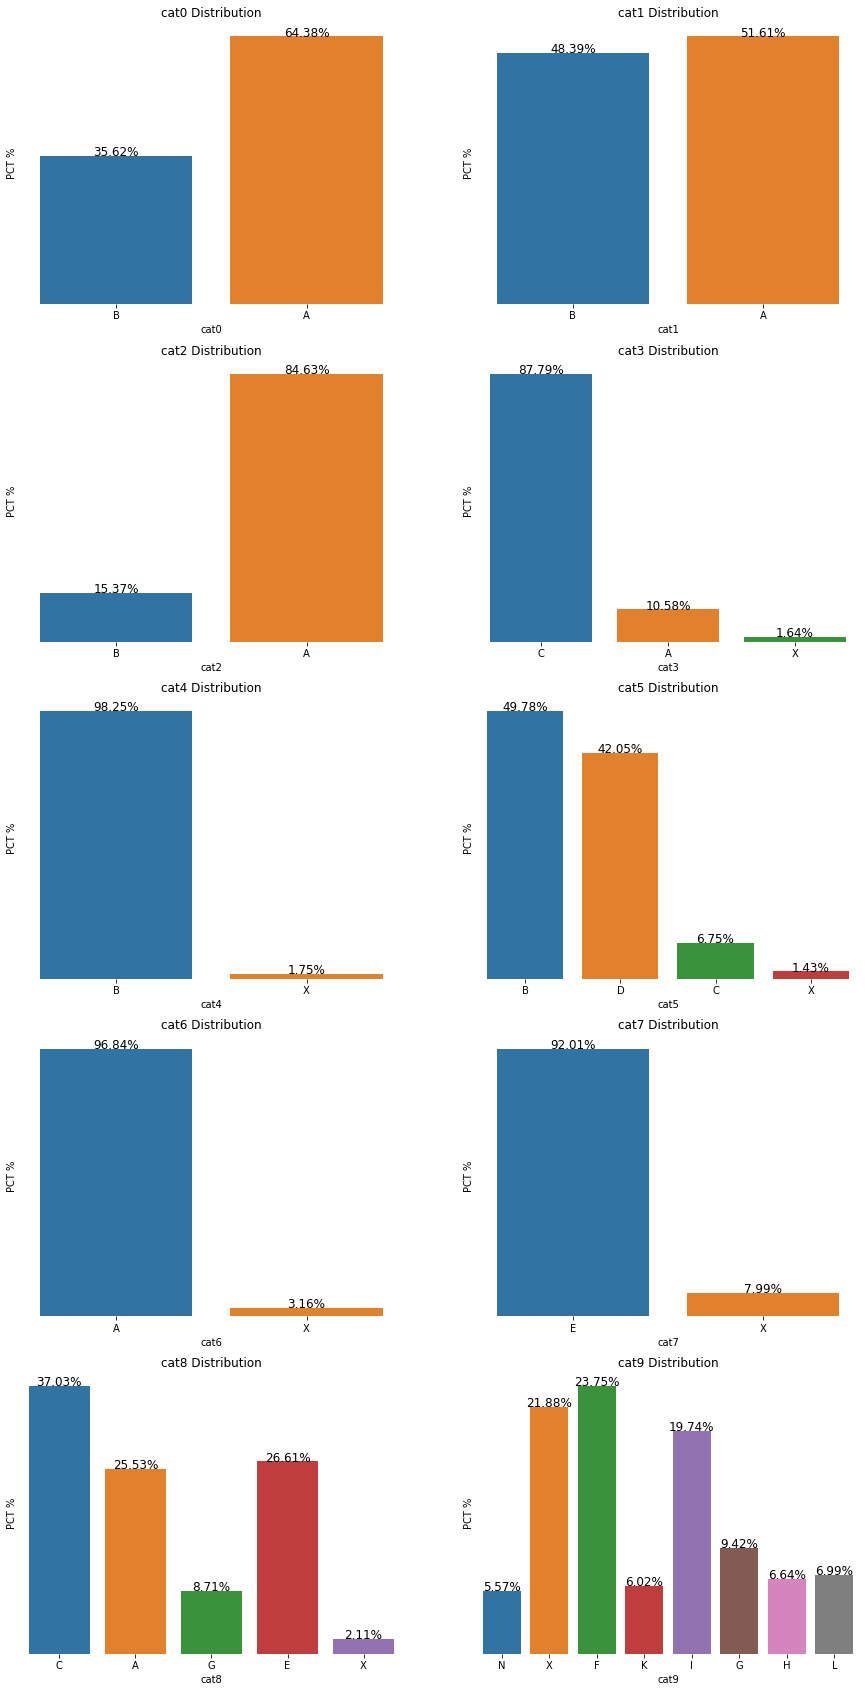

In [162]:
count_plots_cat(df4)

## Modeling
using the df4 where the low frequency values are replaced by X

In [181]:
cat_maps4

{'cat3': {'C': 'C', 'A': 'A', 'D': 'X', 'B': 'X'},
 'cat4': {'B': 'B', 'C': 'X', 'A': 'X', 'D': 'X'},
 'cat5': {'B': 'B', 'D': 'D', 'C': 'C', 'A': 'X'},
 'cat6': {'A': 'A',
  'B': 'X',
  'C': 'X',
  'H': 'X',
  'D': 'X',
  'I': 'X',
  'G': 'X',
  'E': 'X'},
 'cat7': {'E': 'E',
  'F': 'X',
  'D': 'X',
  'B': 'X',
  'G': 'X',
  'C': 'X',
  'A': 'X',
  'I': 'X'},
 'cat8': {'C': 'C',
  'A': 'A',
  'G': 'G',
  'E': 'E',
  'F': 'X',
  'D': 'X',
  'B': 'X'},
 'cat9': {'N': 'N',
  'O': 'X',
  'F': 'F',
  'K': 'K',
  'M': 'X',
  'I': 'I',
  'G': 'G',
  'H': 'H',
  'L': 'L',
  'B': 'X',
  'A': 'X',
  'J': 'X',
  'D': 'X',
  'C': 'X',
  'E': 'X'}}

In [187]:

# dropping cat2 as well

cat_maps4 = {cat:create_maps(cat, df4) for cat in low_freq_categories.keys()}

y4 = df.target.copy()
X4 = df.drop(['cat2','target'], axis=1).copy()
cat_cnames4 = [cname for cname in X4.columns if X4[cname].dtypes=='object']

cat_maps4 = {cat:create_maps(cat, X4) for cat in low_freq_categories.keys()}
X4 = X4.replace(cat_maps)
X4_test = X_test.replace(cat_maps)
X4_train, X4_valid, y4_train, y4_valid = train_test_split(X4, y4, test_size=0.2, random_state=0)

preprocessor4 = ColumnTransformer([('cat', OrdinalEncoder(), cat_cnames4)], remainder='passthrough')
pipeline4 = Pipeline([
    ('preprocessor4', preprocessor4),
    ('model', model)
])
pipeline4.fit(X4_train, y4_train)
model_eval(pipeline4, X4_valid, y4_valid)

RMSE: 0.7220146658176807


0.7220146658176807

In [188]:
pipeline4.fit(X4, y4)


Pipeline(memory=None,
         steps=[('preprocessor4',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat3',
                                                   'cat4', 'cat5', 'cat6',
                                                   'cat7', 'cat8', 'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, b...
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,

In [189]:
preds4 = pipeline4.predict(X4_test.drop('cat2', axis=1))
output_submission(preds4, "submission805")

A submission file has been made at output/submission805


In [193]:
xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':0,
        'n_estimators':10000
        
        
    }
    
model= XGBRegressor(**xgb_params)

In [195]:
preprocessor5 = ColumnTransformer([('cat', OrdinalEncoder(), cat_cnames4)], remainder='passthrough')
pipeline5 = Pipeline([
    ('preprocessor5', preprocessor5),
    ('model', model)
])
pipeline5.fit(X4_train, y4_train)
model_eval(pipeline5, X4_valid, y4_valid)

RMSE: 0.718410525763646


0.718410525763646

In [197]:
# training on full set
pipeline5.fit(X4, y4)

Pipeline(memory=None,
         steps=[('preprocessor5',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat3',
                                                   'cat4', 'cat5', 'cat6',
                                                   'cat7', 'cat8', 'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, b...
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
       

In [199]:
preds5 = pipeline5.predict(X4_test.drop('cat2', axis=1))
output_submission(preds5, "submission806")

A submission file has been made at output/submission806


## Training new params on original dataset with standard scalar

# 1. New params with original dataset w/ standard scalar

In [205]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
num_cnames = create_num_cols(X)
cat_cnames = create_cat_cols(X)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cnames),
    ('cat', OrdinalEncoder(), cat_cnames)
], remainder='passthrough')

xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':0,
        'n_estimators':10000,
        'objective': 'reg:squarederror'
        
        
    }
    
model= XGBRegressor(**xgb_params) 
pipe01 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [ ]:
pipe01.fit(X_train, y_train)


In [210]:
rmse_dict = {}

In [211]:
rmse_dict['rmse01'] = model_eval(pipe01, X_valid, y_valid)

RMSE: 0.7183987409001609


In [212]:
rmse_dict

{'rmse01': 0.7183987409001609}

In [209]:
pipe01['model'].feature_importances_

array([0.03453797, 0.02686649, 0.07106569, 0.04035133, 0.04496418,
       0.05081895, 0.025045  , 0.0617915 , 0.03030444, 0.07586782,
       0.12535924, 0.04206584, 0.12782654, 0.04030283, 0.0082569 ,
       0.10317485, 0.00697158, 0.01087613, 0.00306092, 0.00941005,
       0.00350412, 0.00397043, 0.04295216, 0.01065504], dtype=float32)

# 2. new params, w/ standard scaler and lower values removed

In [213]:
df2 = df[df.target > 6.5]
y2 = df2.target.copy()
X2 = df2.drop('target', axis=1).copy()
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.2, random_state=0)
num_cnames = create_num_cols(X2)
cat_cnames = create_cat_cols(X2)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cnames),
    ('cat', OrdinalEncoder(), cat_cnames)
], remainder='passthrough')

xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':0,
        'n_estimators':10000,
        'objective': 'reg:squarederror'
        
        
    }
    
model= XGBRegressor(**xgb_params) 
pipe02 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [217]:
pipe02.fit(X2_train, y2_train)
rmse_dict['rmse02'] = model_eval(pipe02, X2_valid, y2_valid)

RMSE: 0.7032717827960818


In [218]:
pipe02.fit(X2, y2)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
               

In [219]:
preds02 = pipe02.predict(X_test)

In [221]:
output_submission(preds02, "submission808")

A submission file has been made at output/submission808


In [223]:
preds02

array([8.100878 , 8.408905 , 8.399521 , ..., 8.543701 , 8.195645 ,
       7.9803395], dtype=float32)